In [10]:
#%%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xtrack as xt
import xobjects as xo
import scipy
import xpart as xp

In [15]:
import sympy as sy
from sympy import init_session
init_session() 

IPython console for SymPy 1.13.3 (Python 3.12.7-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.3/



# Ring design

In [36]:
dqx_target, dqy_target = 0, 0

n_part = 1000
N_EX, N_EY = 2e-6, 2e-6
DPP = 1e-5

x_norm, px_norm = xp.generate_2D_gaussian(num_particles=n_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_particles=n_part)

zeta = 0.0
dpp = np.random.rand(n_part) * DPP

# particles = ring.build_particles(
#     method="4d",
#     zeta=zeta,
#     delta=dpp,
#     x_norm=x_norm,
#     px_norm=px_norm,
#     y_norm=y_norm,
#     py_norm=py_norm,
#     nemitt_x=N_EX,
#     nemitt_y=N_EY,
# )

opt = ring.match(solve=False,
    vary=[
        xt.VaryList(['k2f', 'k2d'], step=1e-7),
    ],
    targets=[
        xt.TargetSet(dqx=dqx_target, dqy=dqy_target, tol=1e-3),
    ],
    method='4d')
opt.solve()

Matching: model call n. 0               Matching: model call n. 1               Matching: model call n. 2               Matching: model call n. 3               Matching: model call n. 4               Matching: model call n. 5               Matching: model call n. 6               Matching: model call n. 7               Matching: model call n. 8               Matching: model call n. 9               Matching: model call n. 10               Matching: model call n. 11               Matching: model call n. 12               Matching: model call n. 13               Matching: model call n. 14               Matching: model call n. 15               Matching: model call n. 16               



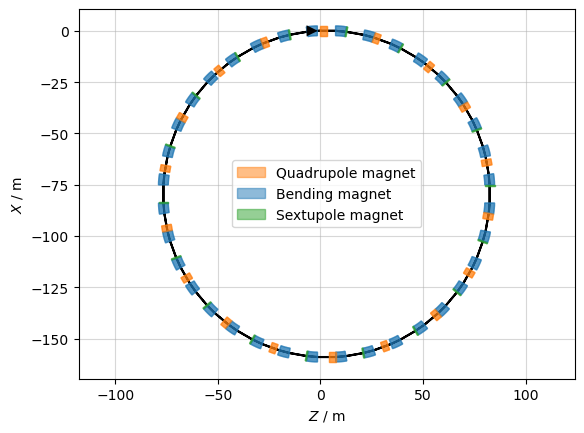

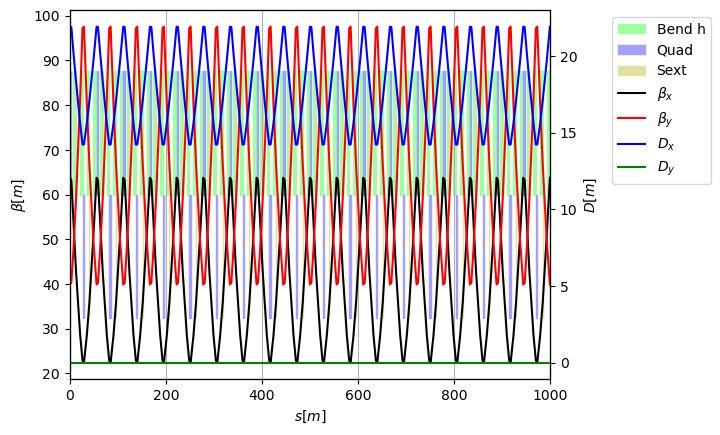

In [37]:
ring.survey().plot()
ring.twiss4d().plot()

In [38]:
ring.to_pandas()[0:12]

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.000000,Marker,_start_point,False,False,None,False,Marker(_dummy=np.int64(0))
1,0.000000,Quadrupole,q1,True,False,None,False,"Quadrupole(k1=0.0111, k1s=0, length=3, num_mul..."
2,3.000000,Drift,drift_1,True,False,None,False,Drift(length=4.39)
3,7.388889,Bend,mb,True,False,None,False,"Bend(length=5, k0=0.0349, k1=0, h=0.0349, mode..."
4,12.388889,Sextupole,sextf,True,False,None,False,"Sextupole(k2=0.0208, k2s=0, length=0.5, _order..."
5,12.888889,Drift,drift_2,True,False,None,False,Drift(length=8.39)
6,21.277778,Bend,mb,True,False,None,False,"Bend(length=5, k0=0.0349, k1=0, h=0.0349, mode..."
7,26.277778,Quadrupole,q2,True,False,None,False,"Quadrupole(k1=-0.0111, k1s=0, length=3, num_mu..."
8,29.277778,Drift,drift_3,True,False,None,False,Drift(length=5.89)
9,35.166667,Bend,mb,True,False,None,False,"Bend(length=5, k0=0.0349, k1=0, h=0.0349, mode..."


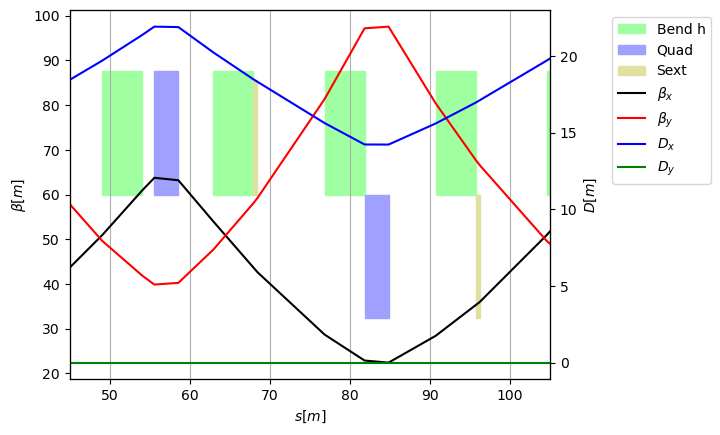

In [40]:
ring.twiss4d().plot()
plt.xlim(45,105)

In [23]:
L=sy.Symbol('L', positive=True, real=True);
f_F=sy.Symbol('f_F', positive=True, real=True);
f_D=sy.Symbol('f_D', positive=True, real=True);
f=sy.Symbol('f', positive=True, real=True);


QF_half=sy.Matrix([[1,0], [-1/(2*f),1]])
DRIFT=sy.Matrix([[1,L], [0,1]])
QD=sy.Matrix([[1,0], [1/f,1]])

In [43]:
lcirc = 1000.0
lquad = 3.0
lbend = 5.0
max_dipole_field = 3.0
number_of_FODO = 20
number_of_dipoles = 2*number_of_FODO
k1 = 0.0098
pc_GeV = 20.0
lFODO = lcirc/number_of_FODO

In [153]:
env = xt.Environment()
env.vars({'lcirc': lcirc,
          'lquad': lquad, 
          'lbend': lbend, 
          'k1f': k1, 
          'k1d': -k1,
          'qtrim_f': 0,
          'qtrim_d': 0,
          'number_of_dipoles': number_of_dipoles,
          'angle.mb': 2.0*np.pi/number_of_dipoles,
          'k0.mb': 'angle.mb/lbend',
          'number_of_fodo': number_of_FODO,
          'lfodo': 'lcirc/number_of_fodo',
          "kick_angle" : -0.01 ,
          "kicker_length" : 2,
          "l_ramp" : 2,
          })

env.particle_ref = xt.Particles(p0c=20e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)

env.new('mb', xt.Bend, length='lbend', k0='k0.mb', h='k0.mb')
env.new('mb0', 'mb') #create each element with unique names in cell -- required for slicing of elements used later
env.new('mb1', 'mb')

#env.new('kicker', xt.Bend, knl = ["kick_angle"], length = "kicker_length")
env.new('kicker', xt.Bend, k0 = "kick_angle/kicker_length", length = "kicker_length")
env.new('mk1', 'kicker') #create each element with unique names in cell -- required for slicing of elements used later
env.new('mk2', 'kicker',  k0 = "-kick_angle/kicker_length")
env.new('mk3', 'kicker',  k0 = "-kick_angle/kicker_length") #create each element with unique names in cell -- required for slicing of elements used later
env.new('mk4', 'kicker')

env.vars({'ksf': 0.00, 'ksd' : 0.00 })

env.new('ms.f', xt.Multipole, knl = [0, 0, 'ksf'])
env.new('ms.d', xt.Multipole, knl = [0, 0, 'ksd'])

env.new('mq', xt.Quadrupole, length='lquad')

env.new('mq.f', 'mq', k1='k1f + qtrim_f')
env.new('mq.d', 'mq', k1='k1d + qtrim_d')

cell_moved_dipole = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.f', at=lquad*0.5),
    env.place('mb0', at='lbend/2+ lquad + 1'),
    env.place('mq.d', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb1', at='1 * lfodo - lquad - lbend/2 - 1'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])

cell = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.f', at=lquad*0.5),
    env.place('mb0', at='0.25 * lfodo + lquad * 0.5'),
    env.place('mq.d', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb1', at='0.75 * lfodo + lquad*0.5'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])
cell.insert_element('ms.f', at = 'mq.f')
cell.insert_element('ms.d', at = 'mq.d')

Baseline ring from exercise 3

In [154]:
line = env.new_line(components=[env.new('_start_point', xt.Marker)]+[env.place(cell_moved_dipole)]*1+[env.place(cell)]*(number_of_FODO-1) )

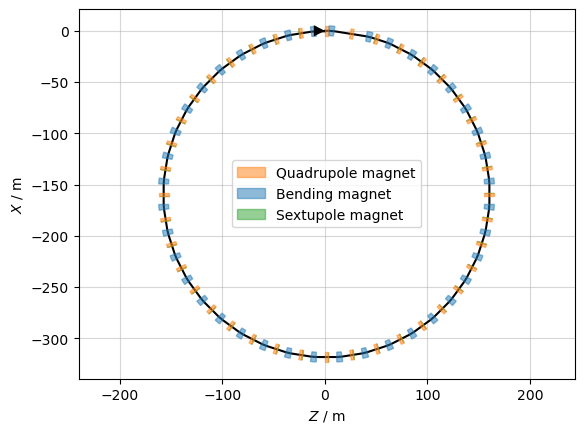

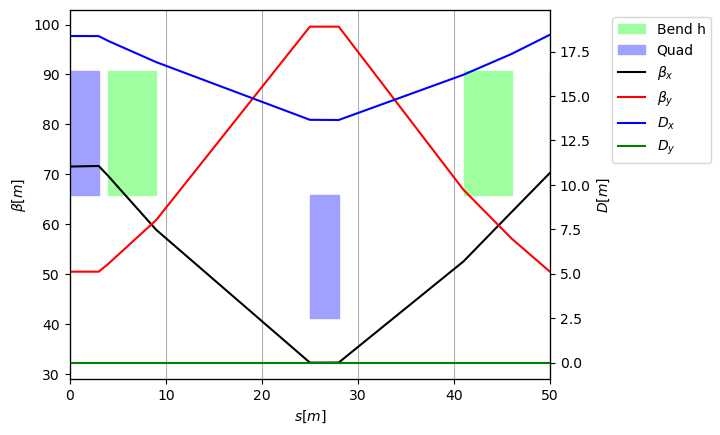

In [155]:
line.survey().plot()
line.twiss4d().plot()
plt.xlim(0,50)

## 25-9

In [157]:
cell_kick = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.f', at=lquad*0.5),
    env.place('mb0', at='lbend/2+ lquad + 1'),
    env.place('mk1', at='lbend + lquad + 1  + kicker_length/2'),
    env.place('mk2', at='lbend+ lquad + 1 +  l_ramp + kicker_length/2'),
    env.place('mk3', at='lbend+ lquad + 1 + 15 - l_ramp - kicker_length/2'),
    env.place('mk4', at='lbend+ lquad + 1 + 15 - kicker_length/2'),
    env.place('mq.d', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb1', at='1 * lfodo - lquad - lbend/2 - 1'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])

In [158]:
cell_kick.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,marker_start,False,False,None,False,Marker(_dummy=np.int64(0))
1,0.0,Quadrupole,mq.f,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
2,3.0,Drift,drift_9,True,False,None,False,Drift(length=1)
3,4.0,Bend,mb0,True,False,None,False,"Bend(length=5, k0=0.0314, k1=0, h=0.0314, mode..."
4,9.0,Bend,mk1,True,False,None,False,"Bend(length=2, k0=-0.005, k1=0, h=0, model='ad..."
5,11.0,Bend,mk2,True,False,None,False,"Bend(length=2, k0=0.005, k1=0, h=0, model='ada..."
6,13.0,Drift,drift_10,True,False,None,False,Drift(length=7)
7,20.0,Bend,mk3,True,False,None,False,"Bend(length=2, k0=0.005, k1=0, h=0, model='ada..."
8,22.0,Bend,mk4,True,False,None,False,"Bend(length=2, k0=-0.005, k1=0, h=0, model='ad..."
9,24.0,Drift,drift_11,True,False,None,False,Drift(length=1)


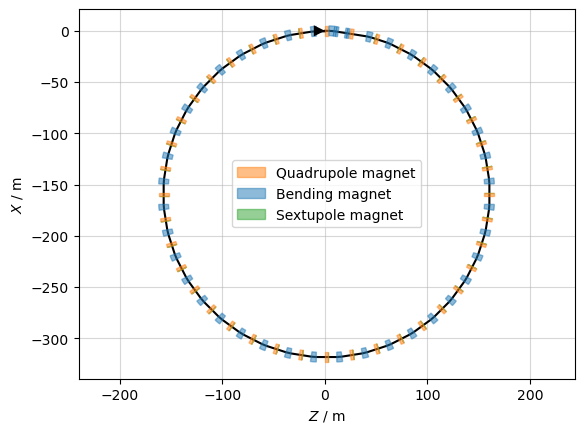

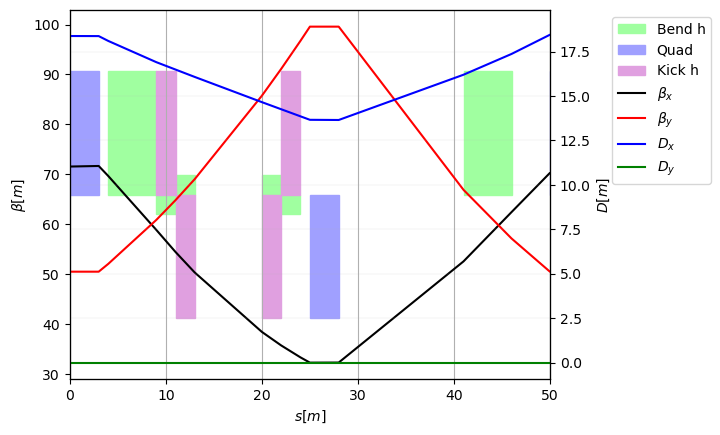

In [159]:
line = env.new_line(components=[env.new('_start_point', xt.Marker)]+[env.place(cell_kick)]*1+[env.place(cell)]*(number_of_FODO-1) )
line.survey().plot()
twiss = line.twiss4d()
twiss.plot()
plt.grid(linewidth = 0.1, which = "both")
plt.xlim(0,50)

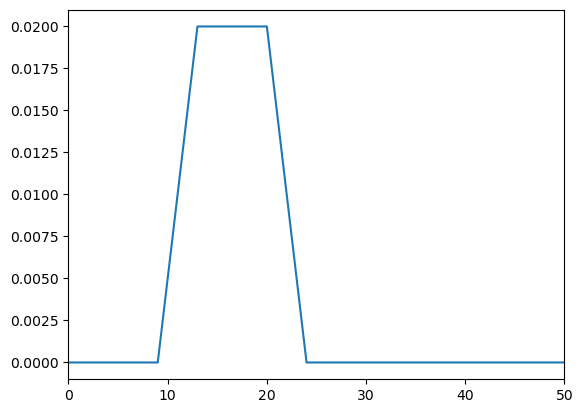

In [160]:
plt.plot(twiss.s, twiss.x)
plt.xlim(0,50)